In [ ]:
# Author : Raude Killian
# Last modified 17.07.205

In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
from scipy.stats import ttest_rel
%matplotlib inline


PARTICIPANTS_FILE = r"L:\Common\Users\Qiaoyue\MEG_project\Data\participants.csv"

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)

participants = pd.read_csv(PARTICIPANTS_FILE)  
participants = participants['subID'].astype(str).tolist()
sessions = ["encoding"]

print(f"✅ Participant list : {participants}")

✅ Participant list : ['F103', 'F104', 'F105', 'F106', 'F107', 'F108', 'F109', 'F111', 'F112', 'F113', 'F114', 'F115', 'F116', 'F117', 'F118', 'F119', 'F120']


In [2]:
# For tests purposes
#participants = ["F103"]

In [2]:
evoked_all_cong = []
evoked_all_incong = []

for subID in participants:

    plots_folder = rf"L:\Common\Users\Qiaoyue\MEG_project\Results\plots\{subID}"
    os.makedirs(plots_folder, exist_ok=True)
    intermediates_folder = rf"L:\Common\Users\Qiaoyue\MEG_project\Results\finals\{subID}"
    #intermediates_folder = rf"C:\Users\killg\Desktop\finals\{subID}"
    os.makedirs(intermediates_folder, exist_ok=True)

    # Declare filenames 
    evoked_filename = rf"{intermediates_folder}/{subID}_encod_cong_evoked.fif"
    evoked = mne.read_evokeds(evoked_filename, verbose=False)[0]
    evoked_all_cong.append(evoked)

    evoked_filename = rf"{intermediates_folder}/{subID}_encod_incong_evoked.fif"
    evoked = mne.read_evokeds(evoked_filename, verbose=False)[0]
    evoked_all_incong.append(evoked)

    print(f"Extracting evoked: {subID}... ")
print(f"✅ Done")

Extracting evoked: F103... 
Extracting evoked: F104... 
Extracting evoked: F105... 
Extracting evoked: F106... 
Extracting evoked: F107... 
Extracting evoked: F108... 
Extracting evoked: F109... 
Extracting evoked: F111... 
Extracting evoked: F112... 
Extracting evoked: F113... 
Extracting evoked: F114... 
Extracting evoked: F115... 
Extracting evoked: F116... 
Extracting evoked: F117... 
Extracting evoked: F118... 
Extracting evoked: F119... 
Extracting evoked: F120... 
✅ Done


t = 0.125, p = 0.902
Cohen's d = 0.031


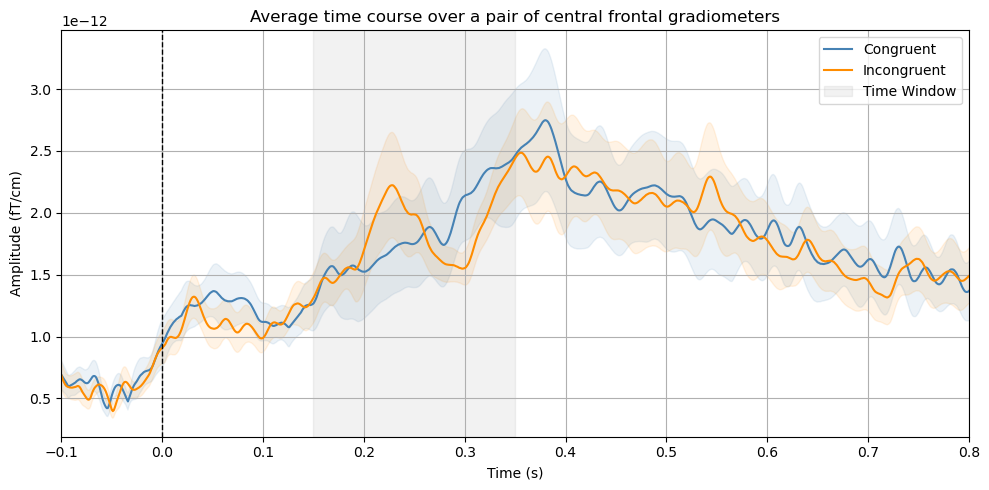

Identifying common channels ...
Identifying common channels ...


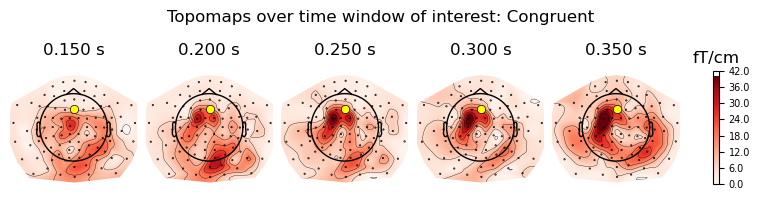

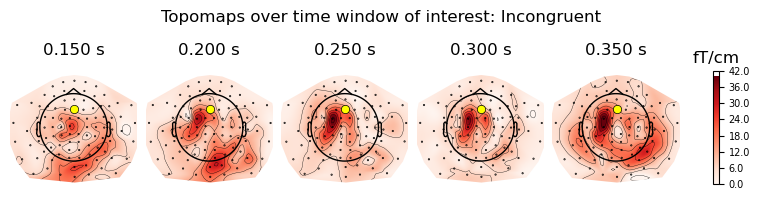

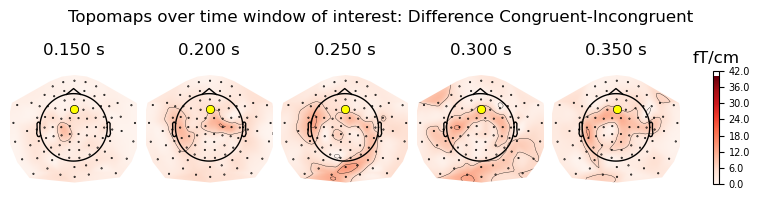

In [16]:
#CHOOSE CHANNEL HERE 
#channels = ["MEG0732","MEG0733"]
#channels = ["MEG0233","MEG0232"] very nice
channels = ["MEG0623","MEG0622"] #frontal

#channels = ["MEG0742","MEG0743"] #parietal 0.1
#channels = ["MEG1332","MEG1333"]

topomap_channel = channels[0]       

cong_data = []
incong_data = []

# Compute vector norm for each epoch
for evoked in evoked_all_cong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    cong_data.append(data)

for evoked in evoked_all_incong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    incong_data.append(data)

del cong_data[5]
del incong_data[5]

time = np.linspace(-0.1, 1.0, len(cong_data[0]))

# --- Compute time course statistics
cong_data = np.array(cong_data)
incong_data = np.array(incong_data)


cong_mean_signal = np.mean(cong_data, axis=0)
cong_se_signal = np.std(cong_data, axis=0) / np.sqrt(len(cong_data))
incong_mean_signal = np.mean(incong_data, axis=0)
incong_se_signal = np.std(incong_data, axis=0) / np.sqrt(len(cong_data))

# --- Statistical analysis
lower_t = 0.15
upper_t = 0.35
time_window = (time >= lower_t) & (time <= upper_t)
cong_amplitudes = np.mean(cong_data[:, time_window], axis=1)
incong_amplitudes = np.mean(incong_data[:, time_window], axis=1)

t_stat, p_value = ttest_rel(cong_amplitudes, incong_amplitudes)
print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

diff = np.array(cong_amplitudes) - np.array(incong_amplitudes)
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)
cohen_d = mean_diff / std_diff
print(f"Cohen's d = {cohen_d:.3f}")


# --- Time course plot
plt.figure(figsize=(10, 5))
plt.plot(time, cong_mean_signal, label='Congruent', color='steelblue')
plt.fill_between(time, cong_mean_signal - cong_se_signal, cong_mean_signal + cong_se_signal, color='steelblue', alpha=0.1)
plt.plot(time, incong_mean_signal, label='Incongruent', color='darkorange')
plt.fill_between(time, incong_mean_signal - incong_se_signal, incong_mean_signal + incong_se_signal, color='darkorange', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT/cm)')
plt.title(f'Average time course over a pair of central frontal gradiometers')
plt.xlim(-0.1, 0.8)
plt.axvline(x=0, linestyle='--', linewidth=1, color='black')
plt.axvspan(lower_t, upper_t, color='grey', alpha=0.1, label="Time Window")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# --- Topomap (only one gradiometer)
times = np.arange(lower_t, upper_t + 0.02, 0.05)
vmin, vmax = 0, 40

avg_cong = mne.grand_average(evoked_all_cong, interpolate_bads=False)
avg_incong = mne.grand_average(evoked_all_incong, interpolate_bads=False)
diff_evoked = mne.combine_evoked([avg_cong, avg_incong], weights=[1, -1])

# --- Create mask for only MEG0742
n_channels = len(avg_cong.ch_names)
n_times = len(avg_cong.times)
mask = np.zeros((n_channels, n_times), dtype=bool)

chan_idx = avg_cong.ch_names.index(topomap_channel)
time_idxs = [np.argmin(np.abs(avg_cong.times - t)) for t in times]
for t in time_idxs:
    mask[chan_idx, t] = True

mask_params = dict(markersize=12, markerfacecolor="yellow")

# --- Plot topomaps
fig = avg_cong.plot_topomap(times, ch_type="grad", show=False,
                            vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Topomaps over time window of interest: Congruent")
plt.show()

fig = avg_incong.plot_topomap(times, ch_type="grad", show=False,
                              vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Topomaps over time window of interest: Incongruent")
plt.show()

fig = diff_evoked.plot_topomap(times, ch_type="grad", show=False,
                               vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Topomaps over time window of interest: Difference Congruent-Incongruent")
plt.show()


t = -1.368, p = 0.192
Cohen's d = -0.342


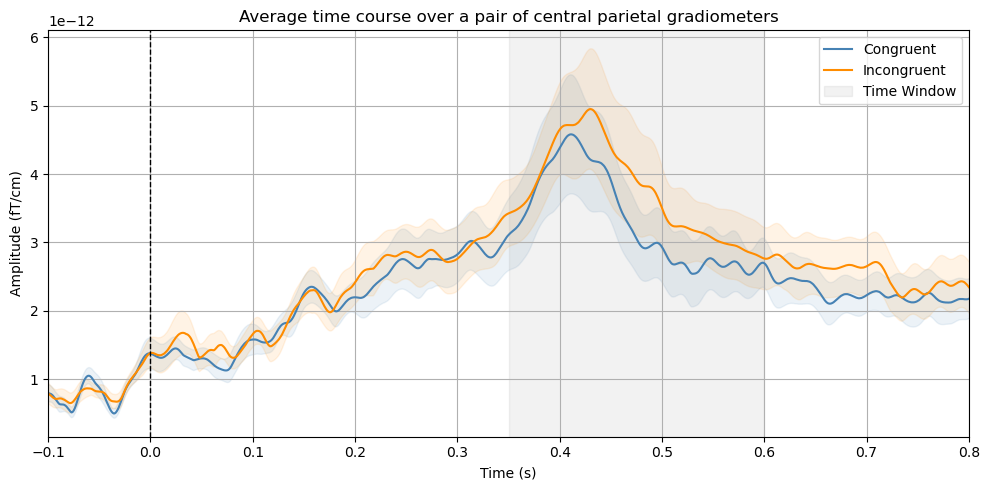

Identifying common channels ...
Identifying common channels ...


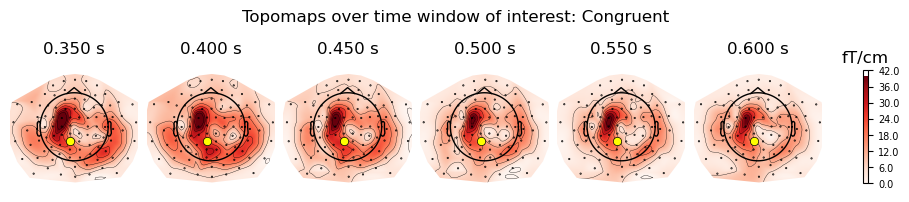

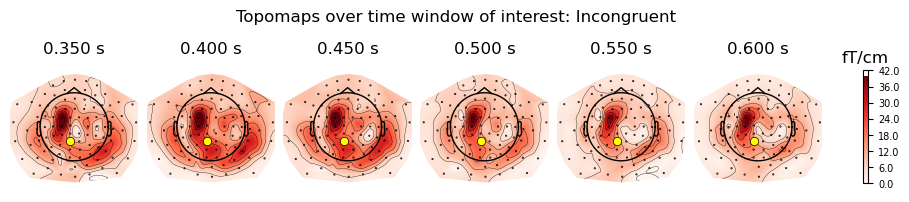

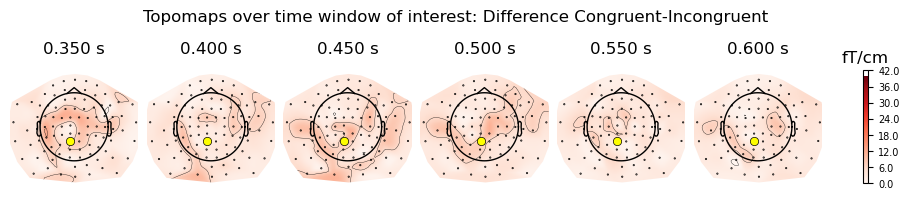

In [15]:
#CHOOSE CHANNEL HERE 
#channels = ["MEG0732","MEG0733"]
#channels = ["MEG0233","MEG0232"] very nice
#channels = ["MEG0623","MEG0622"] #frontal

#channels = ["MEG0742","MEG0743"] #parietal 0.1
#channels = ["MEG1332","MEG1333"]
channels = ["MEG1833","MEG1832"]

topomap_channel = channels[0]       

cong_data = []
incong_data = []

# Compute vector norm for each epoch
for evoked in evoked_all_cong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    cong_data.append(data)

for evoked in evoked_all_incong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    incong_data.append(data)

del cong_data[5]
del incong_data[5]

time = np.linspace(-0.1, 1.0, len(cong_data[0]))

# --- Compute time course statistics
cong_data = np.array(cong_data)
incong_data = np.array(incong_data)


cong_mean_signal = np.mean(cong_data, axis=0)
cong_se_signal = np.std(cong_data, axis=0) / np.sqrt(len(cong_data))
incong_mean_signal = np.mean(incong_data, axis=0)
incong_se_signal = np.std(incong_data, axis=0) / np.sqrt(len(cong_data))

# --- Statistical analysis
lower_t = 0.35
upper_t = 0.6
time_window = (time >= lower_t) & (time <= upper_t)
cong_amplitudes = np.mean(cong_data[:, time_window], axis=1)
incong_amplitudes = np.mean(incong_data[:, time_window], axis=1)

t_stat, p_value = ttest_rel(cong_amplitudes, incong_amplitudes)
print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

diff = np.array(cong_amplitudes) - np.array(incong_amplitudes)
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)
cohen_d = mean_diff / std_diff
print(f"Cohen's d = {cohen_d:.3f}")


# --- Time course plot
plt.figure(figsize=(10, 5))
plt.plot(time, cong_mean_signal, label='Congruent', color='steelblue')
plt.fill_between(time, cong_mean_signal - cong_se_signal, cong_mean_signal + cong_se_signal, color='steelblue', alpha=0.1)
plt.plot(time, incong_mean_signal, label='Incongruent', color='darkorange')
plt.fill_between(time, incong_mean_signal - incong_se_signal, incong_mean_signal + incong_se_signal, color='darkorange', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT/cm)')
plt.title(f'Average time course over a pair of central parietal gradiometers')
plt.xlim(-0.1, 0.8)
plt.axvline(x=0, linestyle='--', linewidth=1, color='black')
plt.axvspan(lower_t, upper_t, color='grey', alpha=0.1, label="Time Window")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# --- Topomap (only one gradiometer)
times = np.arange(lower_t, upper_t + 0.02, 0.05)
vmin, vmax = 0, 40

avg_cong = mne.grand_average(evoked_all_cong, interpolate_bads=False)
avg_incong = mne.grand_average(evoked_all_incong, interpolate_bads=False)
diff_evoked = mne.combine_evoked([avg_cong, avg_incong], weights=[1, -1])

# --- Create mask for only MEG0742
n_channels = len(avg_cong.ch_names)
n_times = len(avg_cong.times)
mask = np.zeros((n_channels, n_times), dtype=bool)

chan_idx = avg_cong.ch_names.index(topomap_channel)
time_idxs = [np.argmin(np.abs(avg_cong.times - t)) for t in times]
for t in time_idxs:
    mask[chan_idx, t] = True

mask_params = dict(markersize=12, markerfacecolor="yellow")

# --- Plot topomaps
fig = avg_cong.plot_topomap(times, ch_type="grad", show=False,
                            vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Topomaps over time window of interest: Congruent")
plt.show()

fig = avg_incong.plot_topomap(times, ch_type="grad", show=False,
                              vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Topomaps over time window of interest: Incongruent")
plt.show()

fig = diff_evoked.plot_topomap(times, ch_type="grad", show=False,
                               vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Topomaps over time window of interest: Difference Congruent-Incongruent")
plt.show()


t = -0.622, p = 0.543
Cohen's d = -0.151


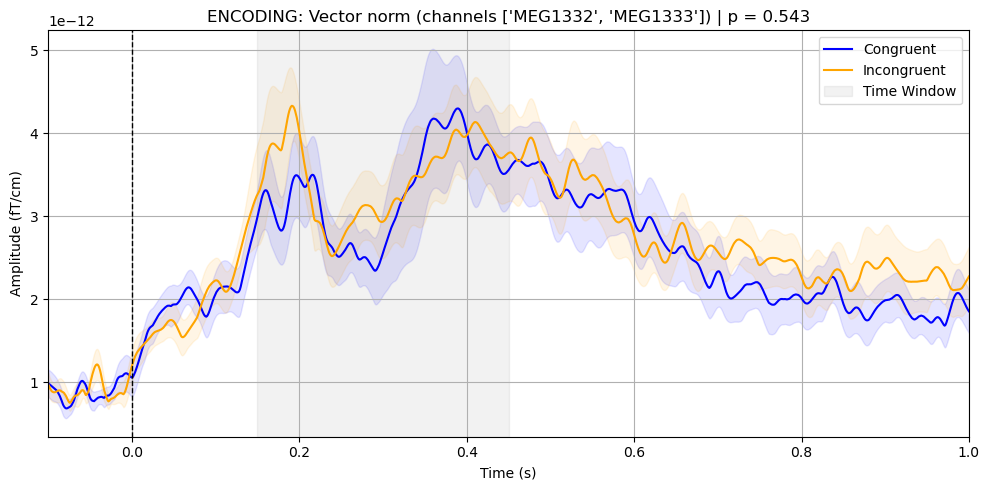

Identifying common channels ...
Identifying common channels ...


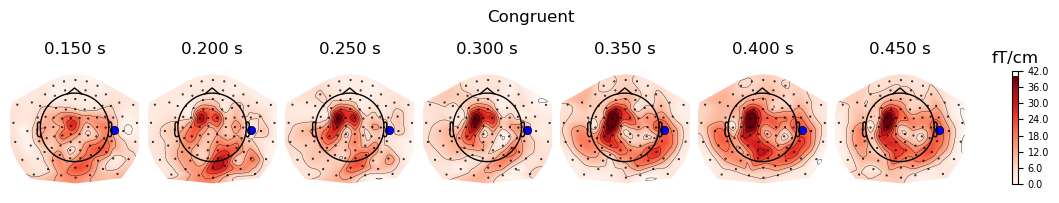

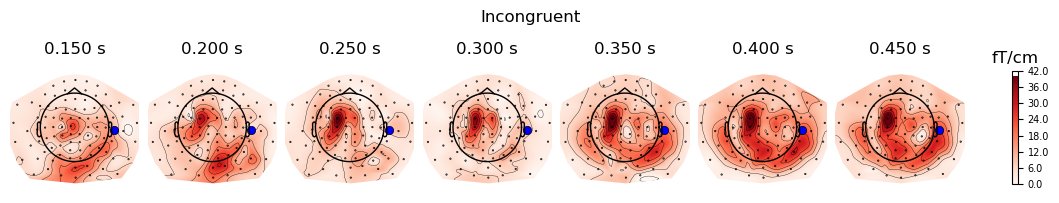

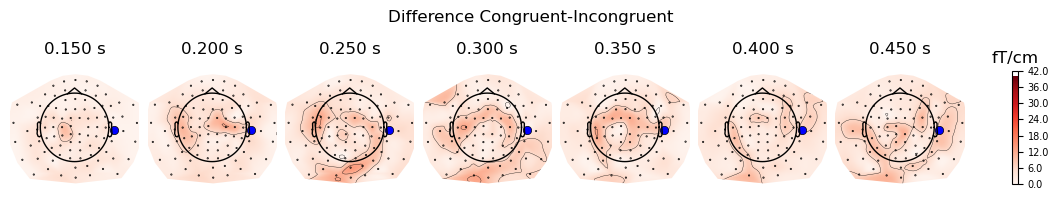

In [ ]:
#CHOOSE CHANNEL HERE 
#channels = ["MEG0732","MEG0733"]
#channels = ["MEG0233","MEG0232"] 
#channels = ["MEG0623","MEG0622"] #frontal

#channels = ["MEG0742","MEG0743"] #parietal 0.1


topomap_channel = channels[0]       

cong_data = []
incong_data = []

# Compute vector norm for each epoch
for evoked in evoked_all_cong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    cong_data.append(data)

for evoked in evoked_all_incong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    incong_data.append(data)

time = np.linspace(-0.1, 1.0, len(cong_data[0]))


# --- Compute time course statistics
cong_data = np.array(cong_data)
incong_data = np.array(incong_data)


cong_mean_signal = np.mean(cong_data, axis=0)
cong_se_signal = np.std(cong_data, axis=0) / np.sqrt(len(cong_data))
incong_mean_signal = np.mean(incong_data, axis=0)
incong_se_signal = np.std(incong_data, axis=0) / np.sqrt(len(cong_data))

# --- Statistical analysis
lower_t = 0.15
upper_t = 0.45
time_window = (time >= lower_t) & (time <= upper_t)
cong_amplitudes = np.mean(cong_data[:, time_window], axis=1)
incong_amplitudes = np.mean(incong_data[:, time_window], axis=1)

t_stat, p_value = ttest_rel(cong_amplitudes, incong_amplitudes)
print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

diff = np.array(cong_amplitudes) - np.array(incong_amplitudes)
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)
cohen_d = mean_diff / std_diff
print(f"Cohen's d = {cohen_d:.3f}")


# --- Time course plot
plt.figure(figsize=(10, 5))
plt.plot(time, cong_mean_signal, label='Congruent', color='steelblue')
plt.fill_between(time, cong_mean_signal - cong_se_signal, cong_mean_signal + cong_se_signal, color='steelblue', alpha=0.1)
plt.plot(time, incong_mean_signal, label='Incongruent', color='darkorange')
plt.fill_between(time, incong_mean_signal - incong_se_signal, incong_mean_signal + incong_se_signal, color='darkorange', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT/cm)')
plt.title(f'ENCODING: Vector norm (channels {channels}) | p = {p_value:.3f}')
plt.xlim(-0.1, 1.0)
plt.axvline(x=0, linestyle='--', linewidth=1, color='black')
plt.axvspan(lower_t, upper_t, color='grey', alpha=0.1, label="Time Window")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# --- Topomap (only one gradiometer)
times = np.arange(lower_t, upper_t + 0.02, 0.05)
vmin, vmax = 0, 40

avg_cong = mne.grand_average(evoked_all_cong, interpolate_bads=False)
avg_incong = mne.grand_average(evoked_all_incong, interpolate_bads=False)
diff_evoked = mne.combine_evoked([avg_cong, avg_incong], weights=[1, -1])

# --- Create mask for only MEG0742
n_channels = len(avg_cong.ch_names)
n_times = len(avg_cong.times)
mask = np.zeros((n_channels, n_times), dtype=bool)

chan_idx = avg_cong.ch_names.index(topomap_channel)
time_idxs = [np.argmin(np.abs(avg_cong.times - t)) for t in times]
for t in time_idxs:
    mask[chan_idx, t] = True

mask_params = dict(markersize=12, markerfacecolor="steelblue")

# --- Plot topomaps
fig = avg_cong.plot_topomap(times, ch_type="grad", show=False,
                            vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Congruent")
plt.show()

fig = avg_incong.plot_topomap(times, ch_type="grad", show=False,
                              vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Incongruent")
plt.show()

fig = diff_evoked.plot_topomap(times, ch_type="grad", show=False,
                               vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Difference Congruent-Incongruent")
plt.show()


t = -1.579, p = 0.135
Cohen's d = -0.395


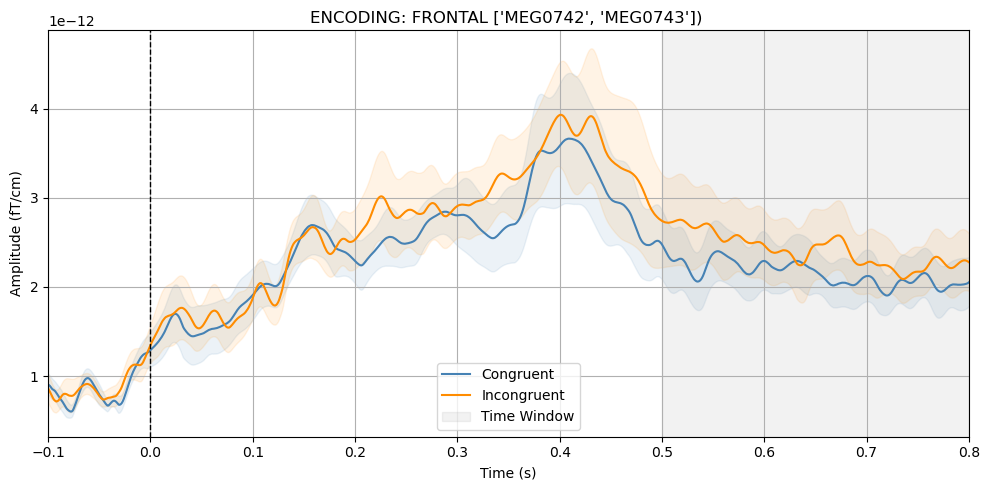

Identifying common channels ...
Identifying common channels ...


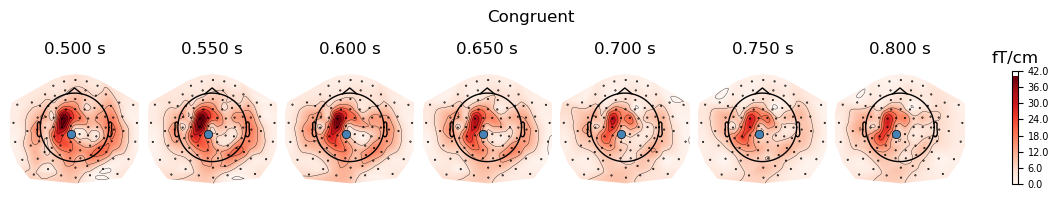

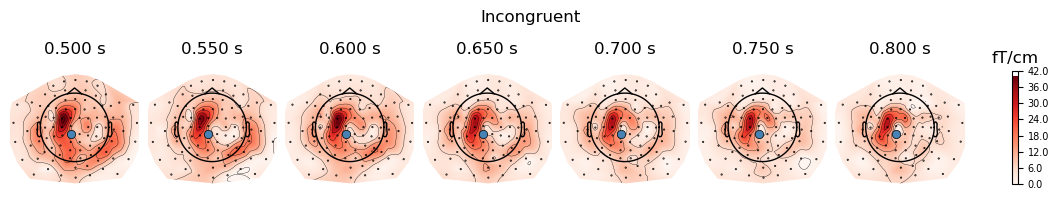

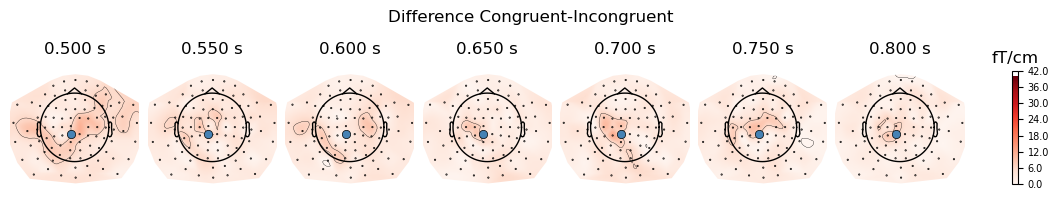

In [11]:
#CHOOSE CHANNEL HERE 
#channels = ["MEG0732","MEG0733"]
#channels = ["MEG0233","MEG0232"] very nice
#channels = ["MEG0623","MEG0622"] #frontal

channels = ["MEG0742","MEG0743"] #parietal 0.1
#channels = ["MEG1332","MEG1333"]

topomap_channel = channels[0]       

cong_data = []
incong_data = []

# Compute vector norm for each epoch
for evoked in evoked_all_cong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    cong_data.append(data)

for evoked in evoked_all_incong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    incong_data.append(data)

del cong_data[5]
del incong_data[5]

time = np.linspace(-0.1, 1.0, len(cong_data[0]))

# --- Compute time course statistics
cong_data = np.array(cong_data)
incong_data = np.array(incong_data)


cong_mean_signal = np.mean(cong_data, axis=0)
cong_se_signal = np.std(cong_data, axis=0) / np.sqrt(len(cong_data))
incong_mean_signal = np.mean(incong_data, axis=0)
incong_se_signal = np.std(incong_data, axis=0) / np.sqrt(len(cong_data))

# --- Statistical analysis
lower_t = 0.5
upper_t = 0.8
time_window = (time >= lower_t) & (time <= upper_t)
cong_amplitudes = np.mean(cong_data[:, time_window], axis=1)
incong_amplitudes = np.mean(incong_data[:, time_window], axis=1)

t_stat, p_value = ttest_rel(cong_amplitudes, incong_amplitudes)
print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

diff = np.array(cong_amplitudes) - np.array(incong_amplitudes)
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)
cohen_d = mean_diff / std_diff
print(f"Cohen's d = {cohen_d:.3f}")


# --- Time course plot
plt.figure(figsize=(10, 5))
plt.plot(time, cong_mean_signal, label='Congruent', color='steelblue')
plt.fill_between(time, cong_mean_signal - cong_se_signal, cong_mean_signal + cong_se_signal, color='steelblue', alpha=0.1)
plt.plot(time, incong_mean_signal, label='Incongruent', color='darkorange')
plt.fill_between(time, incong_mean_signal - incong_se_signal, incong_mean_signal + incong_se_signal, color='darkorange', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT/cm)')
plt.title(f'ENCODING: FRONTAL {channels}) ')
plt.xlim(-0.1, 0.8)
plt.axvline(x=0, linestyle='--', linewidth=1, color='black')
plt.axvspan(lower_t, upper_t, color='grey', alpha=0.1, label="Time Window")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# --- Topomap (only one gradiometer)
times = np.arange(lower_t, upper_t + 0.02, 0.05)
vmin, vmax = 0, 40

avg_cong = mne.grand_average(evoked_all_cong, interpolate_bads=False)
avg_incong = mne.grand_average(evoked_all_incong, interpolate_bads=False)
diff_evoked = mne.combine_evoked([avg_cong, avg_incong], weights=[1, -1])

# --- Create mask for only MEG0742
n_channels = len(avg_cong.ch_names)
n_times = len(avg_cong.times)
mask = np.zeros((n_channels, n_times), dtype=bool)

chan_idx = avg_cong.ch_names.index(topomap_channel)
time_idxs = [np.argmin(np.abs(avg_cong.times - t)) for t in times]
for t in time_idxs:
    mask[chan_idx, t] = True

mask_params = dict(markersize=12, markerfacecolor="steelblue")

# --- Plot topomaps
fig = avg_cong.plot_topomap(times, ch_type="grad", show=False,
                            vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Congruent")
plt.show()

fig = avg_incong.plot_topomap(times, ch_type="grad", show=False,
                              vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Incongruent")
plt.show()

fig = diff_evoked.plot_topomap(times, ch_type="grad", show=False,
                               vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Difference Congruent-Incongruent")
plt.show()


t = 0.259, p = 0.799
Cohen's d = 0.065


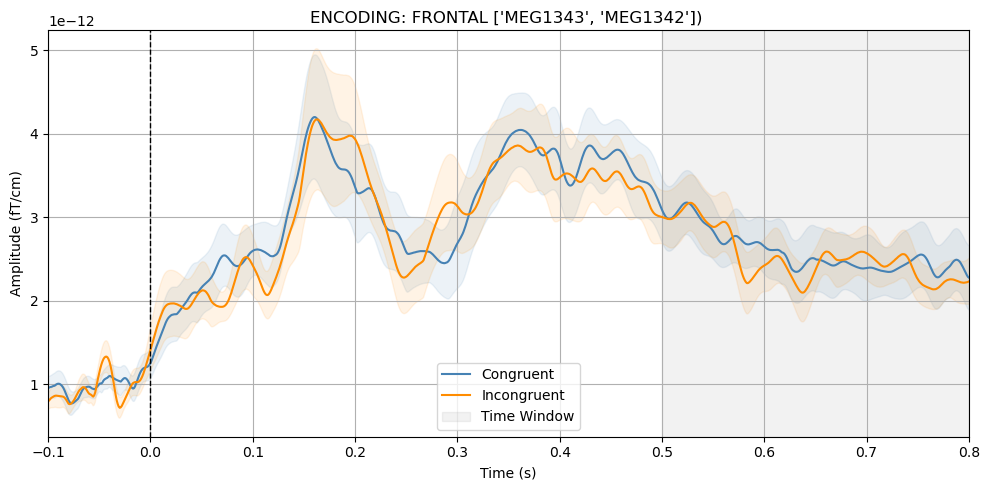

Identifying common channels ...
Identifying common channels ...


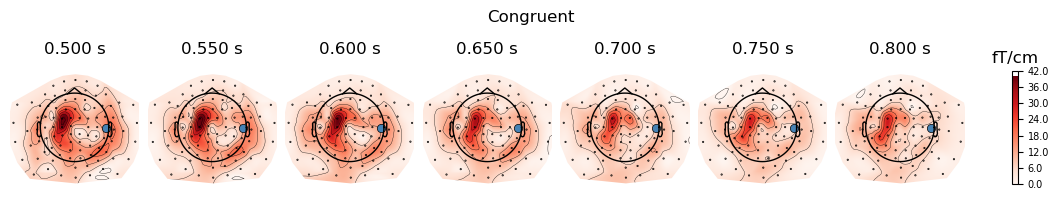

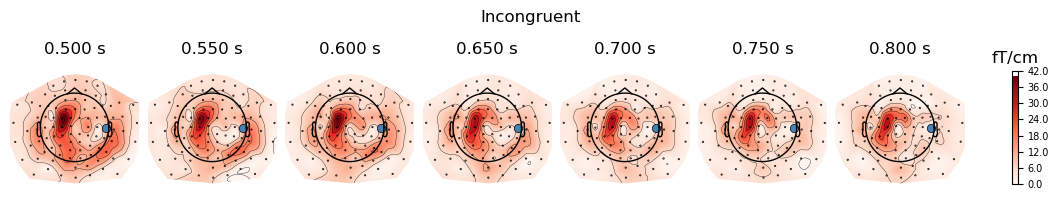

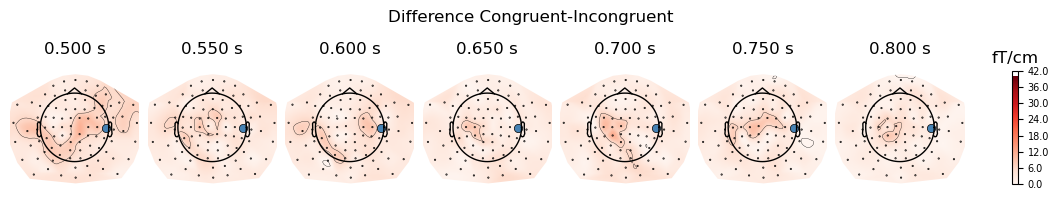

In [14]:
#CHOOSE CHANNEL HERE 
#channels = ["MEG0732","MEG0733"]
#channels = ["MEG0233","MEG0232"] #very nice
#channels = ["MEG0623","MEG0622"] #frontal

#channels = ["MEG0742","MEG0743"] #parietal 0.1
#channels = ["MEG1332","MEG1333"]
channels = ["MEG1343","MEG1342"]

topomap_channel = channels[0]       

cong_data = []
incong_data = []

# Compute vector norm for each epoch
for evoked in evoked_all_cong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    cong_data.append(data)

for evoked in evoked_all_incong:
    item = evoked.copy().pick(channels)
    data = np.sqrt(item.data[0]**2 + item.data[1]**2)
    incong_data.append(data)

del cong_data[5]
del incong_data[5]

time = np.linspace(-0.1, 1.0, len(cong_data[0]))

# --- Compute time course statistics
cong_data = np.array(cong_data)
incong_data = np.array(incong_data)


cong_mean_signal = np.mean(cong_data, axis=0)
cong_se_signal = np.std(cong_data, axis=0) / np.sqrt(len(cong_data))
incong_mean_signal = np.mean(incong_data, axis=0)
incong_se_signal = np.std(incong_data, axis=0) / np.sqrt(len(cong_data))

# --- Statistical analysis
lower_t = 0.5
upper_t = 0.8
time_window = (time >= lower_t) & (time <= upper_t)
cong_amplitudes = np.mean(cong_data[:, time_window], axis=1)
incong_amplitudes = np.mean(incong_data[:, time_window], axis=1)

t_stat, p_value = ttest_rel(cong_amplitudes, incong_amplitudes)
print(f"t = {t_stat:.3f}, p = {p_value:.3f}")

diff = np.array(cong_amplitudes) - np.array(incong_amplitudes)
mean_diff = np.mean(diff)
std_diff = np.std(diff, ddof=1)
cohen_d = mean_diff / std_diff
print(f"Cohen's d = {cohen_d:.3f}")


# --- Time course plot
plt.figure(figsize=(10, 5))
plt.plot(time, cong_mean_signal, label='Congruent', color='steelblue')
plt.fill_between(time, cong_mean_signal - cong_se_signal, cong_mean_signal + cong_se_signal, color='steelblue', alpha=0.1)
plt.plot(time, incong_mean_signal, label='Incongruent', color='darkorange')
plt.fill_between(time, incong_mean_signal - incong_se_signal, incong_mean_signal + incong_se_signal, color='darkorange', alpha=0.1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (fT/cm)')
plt.title(f'ENCODING: FRONTAL {channels}) ')
plt.xlim(-0.1, 0.8)
plt.axvline(x=0, linestyle='--', linewidth=1, color='black')
plt.axvspan(lower_t, upper_t, color='grey', alpha=0.1, label="Time Window")
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

# --- Topomap (only one gradiometer)
times = np.arange(lower_t, upper_t + 0.02, 0.05)
vmin, vmax = 0, 40

avg_cong = mne.grand_average(evoked_all_cong, interpolate_bads=False)
avg_incong = mne.grand_average(evoked_all_incong, interpolate_bads=False)
diff_evoked = mne.combine_evoked([avg_cong, avg_incong], weights=[1, -1])

# --- Create mask for only MEG0742
n_channels = len(avg_cong.ch_names)
n_times = len(avg_cong.times)
mask = np.zeros((n_channels, n_times), dtype=bool)

chan_idx = avg_cong.ch_names.index(topomap_channel)
time_idxs = [np.argmin(np.abs(avg_cong.times - t)) for t in times]
for t in time_idxs:
    mask[chan_idx, t] = True

mask_params = dict(markersize=12, markerfacecolor="steelblue")

# --- Plot topomaps
fig = avg_cong.plot_topomap(times, ch_type="grad", show=False,
                            vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Congruent")
plt.show()

fig = avg_incong.plot_topomap(times, ch_type="grad", show=False,
                              vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Incongruent")
plt.show()

fig = diff_evoked.plot_topomap(times, ch_type="grad", show=False,
                               vlim=(vmin, vmax), mask=mask, mask_params=mask_params)
fig.suptitle(f"Difference Congruent-Incongruent")
plt.show()
